## Libs


In [1]:
%load_ext autoreload
%autoreload 2

import sys
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import jax
import jax.numpy as jnp
import jax.random as jrandom 
import equinox as eqx
import optax
from tqdm.notebook import tqdm
from collections import defaultdict
from functools import partial
import sklearn.neural_network as sknn
from sklearn.datasets import fetch_california_housing, load_diabetes
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer, KNNImputer, SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


jax.config.update('jax_enable_x64', True)
# jax.config.update('jax_check_tracer_leaks', True) 
sys.path.append("../../..")
from lib.ml.base_models import ICNNObsDecoder
import lib.ehr.example_datasets.mimiciv_aki as m4aki
from lib.ehr.tvx_ehr import TVxEHR
from lib.utils import modified_environ, write_config
 

## Data Loading

In [2]:

rng = np.random.RandomState(42)

X_diabetes, y_diabetes = load_diabetes(return_X_y=True)
X_california, y_california = fetch_california_housing(return_X_y=True)
X_california = X_california[:5000]
y_california = y_california[:5000]
X_diabetes = X_diabetes[:5000]
y_diabetes = y_diabetes[:5000]


def add_missing_values(X_full, y_full):
    n_samples, n_features = X_full.shape

    # Add missing values in 75% of the lines
    missing_rate = 0.75
    n_missing_samples = int(n_samples * missing_rate)

    missing_samples = np.zeros(n_samples, dtype=bool)
    missing_samples[:n_missing_samples] = True

    rng.shuffle(missing_samples)
    missing_features = rng.randint(0, n_features, n_missing_samples)
    X_missing = X_full.copy()
    X_missing[missing_samples, missing_features] = np.nan
    y_missing = y_full.copy()

    return X_missing, y_missing


X_miss_california, y_miss_california = add_missing_values(X_california, y_california)
X_miss_diabetes, y_miss_diabetes = add_missing_values(X_diabetes, y_diabetes)

In [3]:
X_miss_california.shape, X_miss_diabetes.shape

((5000, 8), (442, 10))

### Split

In [4]:
rng = np.random.RandomState(0)




In [5]:
from typing import Literal, Callable, Tuple
from sklearn.model_selection import KFold

import equinox as eqx
import jax.nn as jnn
import jax.numpy as jnp
import jax.random as jr
import optax


@eqx.filter_jit
def r_squared(y, y_hat):
    y = y.squeeze()
    y_hat = y_hat.squeeze()
    
    y_bar = y.mean()
    ss_tot = ((y-y_bar)**2).sum()
    ss_res = ((y-y_hat)**2).sum()
    return 1 - (ss_res/ss_tot)


class MLPRegressor(eqx.Module):
    mlp: eqx.nn.MLP
    optimiser: optax.GradientTransformation = eqx.static_field()
    lr: float = eqx.static_field()
    alpha: float = eqx.static_field()
    loss_fn: Callable[[jnp.ndarray], jnp.ndarray] = eqx.static_field()
    batch_size: int = eqx.static_field()
    max_iters: int = eqx.static_field()
    seed: int = eqx.static_field()

    def __init__(self, input_size: int, output_size: int, hidden_size: int, depth: int,
                 activation: Literal['relu', 'tanh', 'sigmoid', 'elu', 'softplus', 'leaky_relu'], batch_size: int,
                 lr: float = 1e-3, alpha: float = 1e-5, loss_fn: Literal['mse', 'mae'] = 'mse',
                 max_iters: int = 100,
                 optax_optimiser = optax.adam,
                 seed: int = 0):
        super().__init__()
        if activation == 'relu':
            activation_f = jnn.relu
        elif activation == 'tanh':
            activation_f = jnn.tanh
        elif activation == 'sigmoid':
            activation_f = jnn.sigmoid
        elif activation == 'softplus':
            activation_f = jnn.softplus
        elif activation == 'elu':
            activation_f = jnn.elu
        elif activation == 'leaky_relu':
            activation_f = lambda x: jnn.leaky_relu(x, negative_slope=0.01)
        else:
            activation_f = lambda x: x

        if loss_fn == 'mse':
            self.loss_fn = jnp.square
        elif loss_fn == 'mae':
            self.loss_fn = jnp.abs
        else:
            raise ValueError(f"Unknown loss function {loss_fn}")

        self.mlp = eqx.nn.MLP(input_size, output_size, hidden_size, depth, activation=activation_f,
                              key=jr.PRNGKey(seed),
                              use_bias=True, use_final_bias=True)
        self.optimiser = optax_optimiser(lr)
        self.lr = lr
        self.alpha = alpha
        self.batch_size = batch_size
        self.max_iters = max_iters
        self.seed = seed

    @eqx.filter_jit
    def loss(self, batch_X: jnp.ndarray, batch_y: jnp.ndarray) -> jnp.ndarray:
        y_hat = eqx.filter_vmap(self.predict)(batch_X)
        return jnp.mean(self.loss_fn(y_hat.flatten() - batch_y.flatten()))

    @property
    def weights_list(self):
        return list(l.weight for l in self.mlp.layers)

    @eqx.filter_value_and_grad
    def loss_grad(self, batch_X: jnp.ndarray, batch_y: jnp.ndarray):
        L = self.loss(batch_X, batch_y)
        if self.alpha > 0:
            L += self.alpha * sum(jnp.sum(jnp.square(w)) for w in self.weights_list) / (2 * len(batch_X))
        return L

    @eqx.filter_jit
    def make_step(self, opt_state, batch_X: jnp.ndarray, batch_y: jnp.ndarray) -> Tuple[
        jnp.ndarray, "MLPRegressor", optax.OptState]:
        loss, grads = self.loss_grad(batch_X, batch_y)
        updates, opt_state = self.optimiser.update(grads, opt_state,
                                                   params=eqx.filter(self, eqx.is_inexact_array),
                                                   value=loss, grad=grads, 
                                                   value_fn=lambda m: eqx.combine(m, self).loss(batch_X, batch_y))
        return loss, eqx.apply_updates(self, updates), opt_state

    @staticmethod
    def dataloader(arrays, batch_size, *, key):
        dataset_size = arrays[0].shape[0]
        indices = jnp.arange(dataset_size)
        while True:
            perm = jr.permutation(key, indices)
            (key, _) = jr.split(key, 2)
            start = 0
            end = batch_size
            while end < dataset_size:
                batch_perm = perm[start:end]
                yield tuple(array[batch_perm] for array in arrays)
                start = end
                end = start + batch_size

    def fit(self, X: jnp.ndarray, y: jnp.ndarray):
        model = self
        opt_state = self.optimiser.init(eqx.filter(model, eqx.is_inexact_array))
        train_batches = self.dataloader((X, y), self.batch_size, key=jr.PRNGKey(self.seed))
        progress = tqdm(range(self.max_iters), leave=False)
        for step, (batch_X, batch_y) in zip(progress, train_batches):
            loss, model, opt_state = model.make_step(opt_state, batch_X, batch_y)
            r2 = r_squared(batch_y, model.predict(batch_X))
            progress.set_description(f"Loss: {loss:.3f}, R2: {r2:.3f}")

        return model

    @eqx.filter_jit
    def predict(self, X: jnp.ndarray):
        if jnp.ndim(X) == 1:
            X = X[None, :]
        return eqx.filter_vmap(self.mlp)(X)


class MLPRegressorICNN(MLPRegressor):
    imputer: ICNNObsDecoder

    def __init__(self, input_size: int, output_size: int, hidden_size: int, depth: int,
                 activation: Literal['relu', 'tanh', 'sigmoid'], batch_size: int,
                 imputer_hidden_size_multiplier: int = 3, imputer_depth: int = 5,
                 lr: float = 1e-3, alpha: float = 1e-5, loss_fn: Literal['mse', 'mae'] = 'mse',
                 max_iters: int = 100,
                 optax_optimiser = optax.adam,
                 icnn_optax_optimiser_name = 'adam',
                 seed: int = 0):
        super().__init__(input_size, output_size, hidden_size, depth, activation, batch_size, lr, alpha, loss_fn,
                         max_iters, optax_optimiser, seed)
        self.imputer = ICNNObsDecoder(observables_size=input_size, state_size=0,
                                      hidden_size_multiplier=imputer_hidden_size_multiplier,
                                      depth=imputer_depth, 
                                      optax_optimiser_name=icnn_optax_optimiser_name,
                                      key=jr.PRNGKey(seed))

    @eqx.filter_jit
    def impute(self, X: jnp.ndarray):
        if jnp.ndim(X) == 1:
            X = X[None, :]
        M = jnp.where(jnp.isnan(X), False, True)
        X = jnp.nan_to_num(X)
        X, aux = eqx.filter_vmap(self.imputer.partial_input_optimise)(X, M)
        return X

    @eqx.filter_jit
    def predict(self, X: jnp.ndarray):
        if jnp.ndim(X) == 1:
            X = X[None, :]
        X = self.impute(X)
        return eqx.filter_vmap(self.mlp)(X)


In [6]:

def get_mlp_regressor(X, opt=optax.adam):
    return MLPRegressor(input_size=X.shape[1],
                        output_size=1, hidden_size=X.shape[1]*5,
                        optax_optimiser=opt,
                        alpha=0., depth=2, activation='leaky_relu', batch_size=32, max_iters=1500, lr=1e-3)


def get_sklearn_mlp_regressor(X):
    return sknn.MLPRegressor(hidden_layer_sizes=(X.shape[1]*5, )*2,
                             solver='lbfgs',
                             alpha=0., activation='relu', batch_size=32, max_iter=1500, learning_rate_init=1e-3)

def get_mlp_icnn_regressor(X, icnn_optax_optimiser_name, opt=optax.adam):
    return MLPRegressorICNN(input_size=X.shape[1],
                            output_size=1, hidden_size=X.shape[1]*5,                       
                            optax_optimiser=opt,
                            icnn_optax_optimiser_name=icnn_optax_optimiser_name,
                            alpha=0., depth=2, activation='leaky_relu', batch_size=32, max_iters=1500, lr=1e-3)


def get_rf_regressor(X = None):
    return RandomForestRegressor(random_state=0)



def get_impute_regress_scores(model, X_missing_train, y_train, X_missing_test, y_test):
    scaler = StandardScaler()
    scaler = scaler.fit(X_missing_train)
    X_missing_train = scaler.transform(X_missing_train)
    X_missing_test = scaler.transform(X_missing_test)
    if isinstance(model, tuple):
        model, imputer = model
        imputer = imputer.fit(X_missing_train)
        X_missing_train = imputer.transform(X_missing_train)
        X_missing_test = imputer.transform(X_missing_test)
        model = model.fit(X_missing_train, y_train)
        ret_model = (model, imputer)
    else:
        model = model.fit(X_missing_train, y_train)
        ret_model = model

    return ({'MSE': np.mean(np.square(model.predict(X_missing_train).flatten() - y_train.flatten())), 
             'R2': r_squared(y_train, model.predict(X_missing_train))},
            {'MSE': np.mean(np.square(model.predict(X_missing_test).flatten() - y_test.flatten())), 
             'R2': r_squared(y_test, model.predict(X_missing_test))}), ret_model

def get_imput_regress_scores_cv(model, X, y, k=5):
    kf = KFold(n_splits=k, shuffle=True, random_state=0)
    train_mse, train_r2 = [], []
    test_mse, test_r2 = [], []
    
    for i, (train_index, test_index) in enumerate(kf.split(X)):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        (train_scores, test_scores), model = get_impute_regress_scores(model, X_train, y_train, X_test, y_test)
        train_mse.append(train_scores['MSE'])
        train_r2.append(train_scores['R2'])
        test_mse.append(test_scores['MSE'])
        test_r2.append(test_scores['R2'])
    

    return pd.DataFrame({'split': ['TRAIN'] * k +  ['TEST'] * k,
                        'MSE': train_mse + test_mse,
                        'R2':  train_r2 + test_r2,
                        'Fold': list(range(k)) * 2})



In [131]:
optax_optimisers = {
    'adam': optax.adam,
    'polyak_sgd': optax.polyak_sgd,
    'novograd': optax.novograd,
    'lamb': optax.lamb,
    'yogi': optax.yogi,
}


imputers =  {
    'zero_imputer': lambda: SimpleImputer(missing_values=np.nan, add_indicator=False, strategy="constant", fill_value=0),
    'mean_imputer': lambda: SimpleImputer(missing_values=np.nan, add_indicator=False, strategy="mean", fill_value=0),
    'knn_imputer': lambda: KNNImputer(missing_values=np.nan),
    'iter_imputer': lambda: IterativeImputer(
        missing_values=np.nan,
        add_indicator=False,
        random_state=0,
        n_nearest_features=5,
        max_iter=5,
        sample_posterior=True,
    )
}

In [8]:
dfs = []

In [9]:
for (ds_name, (X, y)) in zip(['California',
                             'Diabetes'
                             ],  [(X_miss_california, y_miss_california), 
                                  (X_miss_diabetes, y_miss_diabetes)
                                 ]):

    for imputer_name, imputer in imputers.items():
        for model_name, model in [('SKL_MLP', get_sklearn_mlp_regressor(X)), ('SKL_RF', get_rf_regressor())]:
            res = get_imput_regress_scores_cv((model,imputer()), X, y)
            res['Dataset'] = ds_name
            res['Imputer'] = imputer_name
            res['Model'] = model_name
            dfs.append(res)

        for opt_name, optimizer in optax_optimisers.items():
            model_name = 'JAX_MLP'
            model = get_mlp_regressor(X, opt=optimizer)
            res = get_imput_regress_scores_cv((model,imputer), X, y)
            res['Dataset'] = ds_name
            res['Imputer'] = imputer_name
            res['Model'] = model_name
            res['Optimizer'] = opt_name
            dfs.append(res)

pd.concat(dfs).to_csv('feedforward_imputations.csv')

/home/asem/GP/env/icenode-dev/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
2024-07-01 10:25:35.968897: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.4.131). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
/home/asem/GP/env/icenode-dev/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

/home/asem/GP/env/icenode-dev/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/asem/GP/env/icenode-dev/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/asem/GP/env/icenode-dev/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs faile

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

/home/asem/GP/env/icenode-dev/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/asem/GP/env/icenode-dev/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/asem/GP/env/icenode-dev/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs faile

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

/home/asem/GP/env/icenode-dev/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/asem/GP/env/icenode-dev/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/asem/GP/env/icenode-dev/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs faile

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

/home/asem/GP/env/icenode-dev/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/asem/GP/env/icenode-dev/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

/home/asem/GP/env/icenode-dev/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/asem/GP/env/icenode-dev/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/asem/GP/env/icenode-dev/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs faile

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

/home/asem/GP/env/icenode-dev/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

In [ ]:
for (ds_name, (X, y)) in zip(['California',
                             'Diabetes'
                             ],  [(X_miss_california, y_miss_california), 
                                  (X_miss_diabetes, y_miss_diabetes)
                                 ]):
    for opt_name, optimizer in optax_optimisers.items():
        model_name = 'JAX_MLP_ICNN'
        for icnn_opt_name in ['adam', 'polyak_sgd', 'lamb', 'yogi']:
            model = get_mlp_icnn_regressor(X, opt=optimizer, icnn_optax_optimiser_name=icnn_opt_name)
            resicnn = get_imput_regress_scores_cv(model, X, y)
            resicnn['Dataset'] = ds_name
            resicnn['Model'] = model_name
            resicnn['Optimizer'] = opt_name
            resicnn['ICNN-Opt'] = icnn_opt_name
            dfs.append(resicnn)
    

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

In [14]:
print('x')

x


In [ ]:
print('x')

In [ ]:
print('z')

In [77]:
results = pd.concat(dfs)
results['R2'] = results['R2'].astype(float)
results_train_cal = results[(results.split == 'TRAIN') & (results.Dataset == 'California')]
results_train_diab = results[(results.split == 'TRAIN') & (results.Dataset == 'Diabetes')]


In [78]:
# results.to_csv('results_icnn_3_july.csv')

In [79]:
results_train_cal_icnn = results[(results.split == 'TRAIN') & (results.Dataset == 'California') & (results.Model == 'JAX_MLP_ICNN') ]
results_train_diab_icnn = results[(results.split == 'TRAIN') & (results.Dataset == 'Diabetes') & (results.Model == 'JAX_MLP_ICNN') ]
results_test_cal_icnn = results[(results.split == 'TEST') & (results.Dataset == 'California') & (results.Model == 'JAX_MLP_ICNN') ]
results_test_diab_icnn = results[(results.split == 'TEST') & (results.Dataset == 'Diabetes') & (results.Model == 'JAX_MLP_ICNN') ]

<Axes: xlabel='R2', ylabel='Optimizer'>

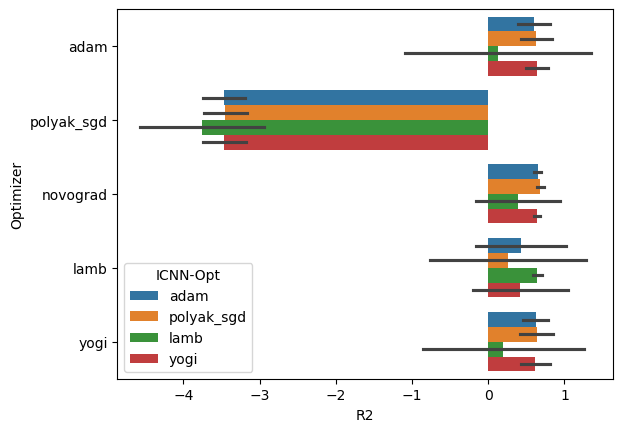

In [80]:
import seaborn as sns


sns.barplot(results_test_cal_icnn,  x="R2", y="Optimizer", hue="ICNN-Opt", errorbar="sd" )


<Axes: xlabel='R2', ylabel='Optimizer'>

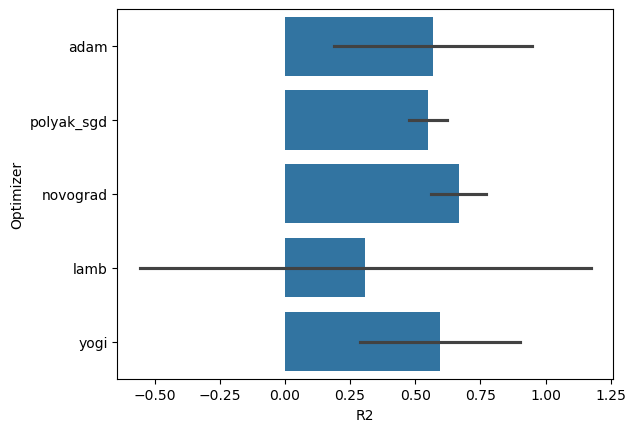

In [81]:
results_train_cal_jxmlp = results[(results.split == 'TRAIN') & (results.Dataset == 'California') & (results.Model == 'JAX_MLP')]
results_train_diab_jxmlp = results[(results.split == 'TRAIN') & (results.Dataset == 'Diabetes') & (results.Model == 'JAX_MLP')]
results_test_cal_jxmlp = results[(results.split == 'TEST') & (results.Dataset == 'California') & (results.Model == 'JAX_MLP')]
results_test_diab_jxmlp = results[(results.split == 'TEST') & (results.Dataset == 'Diabetes') & (results.Model == 'JAX_MLP')]
sns.barplot(results_test_cal_jxmlp,  x="R2", y="Optimizer", errorbar="sd" )


In [82]:
selected_methods = [
    results[results.Optimizer.isin(('novograd', 'adam')) & results["ICNN-Opt"].isin(('adam', 'polyak_sgd'))],
    results[results.Optimizer.isin(('novograd', 'adam')) & (results["Model"] == 'JAX_MLP')],
    results[~results.Model.isin(('JAX_MLP', 'JAX_MLP_ICNN'))]
]
selected_methods = pd.concat(selected_methods)
selected_methods['Method'] = selected_methods.apply(lambda x: x["Model"] + ' (' + ', '.join(filter(lambda x: x == x, [x['Optimizer'], x['ICNN-Opt'], x['Imputer']])) + ')', axis=1)


<Axes: xlabel='R2', ylabel='Method'>

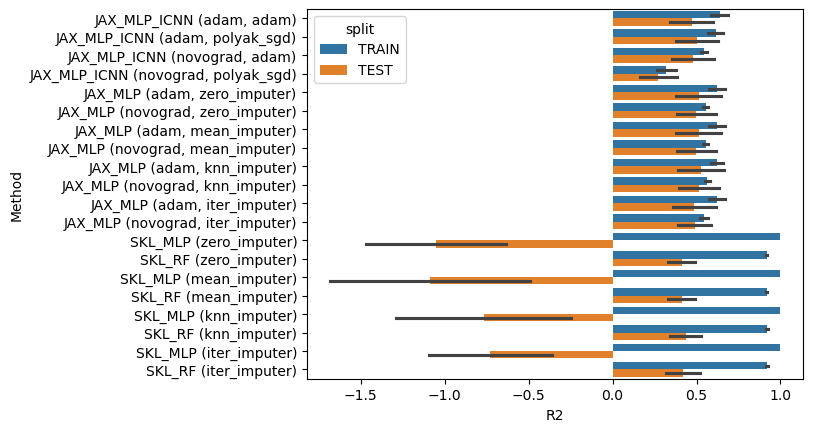

In [83]:
sns.barplot(selected_methods[(selected_methods.Dataset == 'Diabetes')], #& (selected_methods.Method != 'SKL_MLP (knn_imputer)')], 
            x="R2", y="Method", hue="split", errorbar="sd" )


## Imputation-only Performance

In [132]:
def train_icnn_imputer(X_missing, y, optimizer, icnn_optimizer):
    m = {}
    m['scaler'] = StandardScaler().fit(X_missing)
    X_missing = m['scaler'].transform(X_missing)
    m['model'] = get_mlp_icnn_regressor(X_missing, opt=optimizer, icnn_optax_optimiser_name=icnn_optimizer)
    m['model'] = m['model'].fit(X_missing, y)
    m['impute'] = lambda m, X:  np.array(m['model'].impute(jnp.array(m['scaler'].transform(X))))
    return m

    
def train_sklearn_imputer(imputer_name, X_missing):
    m = {}
    m['scaler'] =  StandardScaler().fit(X_missing)
    X_missing = m['scaler'].transform(X_missing)
    m['imputer'] = imputers[imputer_name]().fit(X_missing)
    m['impute'] = lambda m, X: m['imputer'].transform(m['scaler'].transform(X))
    return m


def per_feature_imputer_performance(imputer, X_full, X_missing):
    missing_mask = np.where(np.isnan(X_missing), True, False)
    X_imputed = imputer['impute'](imputer, X_missing)
    r2 = np.empty(X_full.shape[1]) + float('nan')
    for i in range(X_full.shape[1]):
        m = missing_mask[:, i]
        y_hat = X_imputed[:, i]
        y = X_full[:, i]
        r2[i] = r_squared(y[m], y_hat[m])
    return r2

diabetes_trained_imputer = {
    k: train_sklearn_imputer(k, X_diabetes) for k in imputers.keys()} | {
    'ICNN': train_icnn_imputer(X_diabetes, y_diabetes, optax_optimisers['adam'], 'adam')
    }

california_trained_imputer = {
    k: train_sklearn_imputer(k, X_california) for k in imputers.keys()} | {
    'ICNN': train_icnn_imputer(X_california, y_california, optax_optimisers['adam'], 'adam')
    }

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

In [124]:
diabetes_trained_imputer.keys()

dict_keys(['zero_imputer', 'mean_imputer', 'knn_imputer', 'iter_imputer', 'ICNN'])

In [119]:
# X_diabetes.var(axis=0)

In [130]:
diabetes_trained_imputer['zero_imputer']['imputer'].n_features_in_

10

In [126]:
dir(diabetes_trained_imputer['zero_imputer']['imputer'])

['__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__sklearn_clone__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_build_request_for_signature',
 '_check_feature_names',
 '_check_n_features',
 '_concatenate_indicator',
 '_concatenate_indicator_feature_names_out',
 '_dense_fit',
 '_doc_link_module',
 '_doc_link_template',
 '_doc_link_url_param_generator',
 '_fit_dtype',
 '_fit_indicator',
 '_get_default_requests',
 '_get_doc_link',
 '_get_metadata_request',
 '_get_param_names',
 '_get_tags',
 '_more_tags',
 '_parameter_constraints',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_sklearn_auto_wrap_output_keys',
 '_sparse_fit',
 '_transform_indic

In [133]:
diabetes_r2_scores = {k: per_feature_imputer_performance(v, X_diabetes, X_miss_diabetes) for k, v in diabetes_trained_imputer.items() }

In [135]:
california_r2_scores = {k: per_feature_imputer_performance(v, X_california, X_miss_california) for k, v in california_trained_imputer.items() }

In [134]:
diabetes_r2_scores

{'zero_imputer': array([-7.35074048e-02, -1.15169632e-04, -1.63338351e-02, -1.48952248e-07,
        -1.51834805e-04, -1.27593018e-02, -7.75727772e-04, -5.40909049e-02,
        -4.27478745e-05, -1.83469282e-03]),
 'mean_imputer': array([-7.35074048e-02, -1.15169632e-04, -1.63338351e-02, -1.48952248e-07,
        -1.51834805e-04, -1.27593018e-02, -7.75727772e-04, -5.40909049e-02,
        -4.27478745e-05, -1.83469282e-03]),
 'knn_imputer': array([-158.01823263, -151.84870549, -193.99752244, -111.36227316,
        -280.26319251, -262.32089972, -239.96176373, -278.7313385 ,
        -200.07128864, -130.59398063]),
 'iter_imputer': array([-364.46560955, -558.2542973 , -762.5250634 , -256.60781392,
        -531.2503232 , -561.60998428, -451.36732655, -536.74331587,
        -383.58604848, -518.82908162]),
 'ICNN': array([-451.36555449, -458.88254112, -628.6989605 , -377.34478889,
        -698.53057442, -494.21676829, -597.71115613, -513.12404981,
        -479.54203959, -427.3910806 ])}

In [136]:
diabetes_r2_scores

{'zero_imputer': array([-7.35074048e-02, -1.15169632e-04, -1.63338351e-02, -1.48952248e-07,
        -1.51834805e-04, -1.27593018e-02, -7.75727772e-04, -5.40909049e-02,
        -4.27478745e-05, -1.83469282e-03]),
 'mean_imputer': array([-7.35074048e-02, -1.15169632e-04, -1.63338351e-02, -1.48952248e-07,
        -1.51834805e-04, -1.27593018e-02, -7.75727772e-04, -5.40909049e-02,
        -4.27478745e-05, -1.83469282e-03]),
 'knn_imputer': array([-158.01823263, -151.84870549, -193.99752244, -111.36227316,
        -280.26319251, -262.32089972, -239.96176373, -278.7313385 ,
        -200.07128864, -130.59398063]),
 'iter_imputer': array([-364.46560955, -558.2542973 , -762.5250634 , -256.60781392,
        -531.2503232 , -561.60998428, -451.36732655, -536.74331587,
        -383.58604848, -518.82908162]),
 'ICNN': array([-451.36555449, -458.88254112, -628.6989605 , -377.34478889,
        -698.53057442, -494.21676829, -597.71115613, -513.12404981,
        -479.54203959, -427.3910806 ])}